# Text classification of dream accounts using Random Forest

Many people struggle to interpret their dreams and the meaning of various symbols or elements. Creating a tool that automatically codes specific elements of dreams can present an opportunity to highlight significant themes that may provide insight into an individual dreamer’s unconscious. This project trains a model to determine emotions present in a text dream account using a [dataset](https://datadryad.org/stash/dataset/doi:10.5061/dryad.qbzkh18fr) containing dream reports that was used by researchers who wrote a paper titled [Our dreams, our selves: automatic analysis of dream reports](https://datadryad.org/stash/dataset/doi:10.5061/dryad.qbzkh18fr). The researchers sourced the dream data, a collection of 20k+ dream reports, from [dreambank.net](http://www.dreambank.net). The dataset contains journal-like text accounts of dreams from a number of individuals that have been coded using the [Hall/Van de Castle dream coding system](https://dreams.ucsc.edu/Coding/). This system was developed by psychologists as a method for doing quantitative content analysis on dreams. It assigns quantitative values to several dream elements: characters (male/female, animal, family, etc), aggression or friendliness of interactions, negative/positive emotions. The dataset also includes information on the dreamers’ profiles and dates of dreams. 

## Import libraries

In [1]:
import sklearn 
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## Load dream dataset csv file

In [2]:
df_dreams = pd.read_csv('data/rsos_dream_data.csv')
df_dreams.head(8)
df_dreams.shape

(21001, 21)

## Data cleaning steps

In [3]:
df_dreams = df_dreams[['text_dream','emotions_code']].dropna()

In [4]:
df_dreams['text_dream'] = df_dreams['text_dream'].str.lower()

In [5]:
df_dreams.head(8)

,text_dream,emotions_code
1,i'm at a family reunion in a large fine house ...,SD 2IKA
2,i watch a plane fly past and shortly realize i...,"SD 1ISA, AP D, AP D"
3,me pulling the green leaves and berries off so...,"SD 2ISA, SD D"
4,i'm in a room that reminds me of (but definite...,"AP D, AP D, AP 1MSA, CO D, SD D, AP D"
5,living next door to loretta in an apartment - ...,HA 1FSA
6,kidnapped - i'm on my way somewhere else (by c...,"AN 1ISA, AN D, SD 2ISA, AN D"
7,"i'm alone in an apartment - old place, inside ...","AP D, SD D"
11,me and mb (one of my cats) in a big fancy dark...,"AP 1ISA, SD 2ISA, AP 1IKA"


In [6]:
df_dreams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11086 entries, 1 to 20999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_dream     11086 non-null  object
 1   emotions_code  11086 non-null  object
dtypes: object(2)
memory usage: 259.8+ KB


## Split emotions_code column to keep only the first emotion code (for simplicity).

In [7]:
df_dreams["emotion_code"] = df_dreams['emotions_code'].str.split(" ", n = 1, expand = True)[0]

In [8]:
df_dreams["emotion_code"].value_counts()

AP             3503
HA             2161
AN             2117
CO             1682
SD             1612
AP1IKA,           2
CO1IKA,           2
AP1IKA            2
MAN1MKA           1
CO1IKA            1
WOMAN2IDA         1
INDIAN1IEA        1
REAGAN1IKA,       1
Name: emotion_code, dtype: int64

In [9]:
df_dreams.shape

(11086, 3)

## Keep only values with the dream codes we want to work with and defining the dream codes in a Python dictonary.

In [10]:
target_codes = ["AP", "HA", "AN", "CO", "SD"]

df_dreams = df_dreams[df_dreams['emotion_code'].isin(target_codes)]

In [11]:
categories = {
    'AP': 'Apprehension',
    'HA': 'Happiness',
    'AN': 'Anger',
    'CO': 'Confusion',
    'SD': 'Sadness'
}

print(categories)

{'AP': 'Apprehension', 'HA': 'Happiness', 'AN': 'Anger', 'CO': 'Confusion', 'SD': 'Sadness'}


In [12]:
df_dreams.shape

(11075, 3)

## Change the data type from string to list.

In [13]:
X = df_dreams['text_dream'].to_list()
y = df_dreams['emotion_code'].to_list()

In [14]:
type(X), len(X)

(list, 11075)

In [15]:
len(X),len(y)

(11075, 11075)

## Split the data into training and test sets.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
print("X_train shape: {}" .format(len(X_train)))
print("y_train shape: {}" .format(len(y_train)))

X_train shape: 8860
y_train shape: 8860


In [18]:
print("X_test shape: {}" .format(len(X_test)))
print("y_test shape: {}" .format(len(y_test)))

X_test shape: 2215
y_test shape: 2215


### Build a pipeline to tokenize text, determine term frequencies, and train a random forest classifier.

In [19]:
text_clf = Pipeline([
    ('vect', CountVectorizer(lowercase=False, stop_words="english", ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_jobs=-1)),
])

In [20]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(lowercase=False, ngram_range=(1, 2),
                                 stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_jobs=-1))])

### Evaluate performance of test set.

In [21]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.5038374717832957

## Confusion matrix

In [22]:
cm = confusion_matrix(y_test,predicted, labels=text_clf.classes_)
cm

array([[201, 217,   1,   9,   4],
       [ 18, 632,   2,  17,   4],
       [ 20, 247,  56,  23,   5],
       [ 18, 251,   2, 163,   4],
       [ 17, 223,   3,  14,  64]])

## Plot confusion matrix

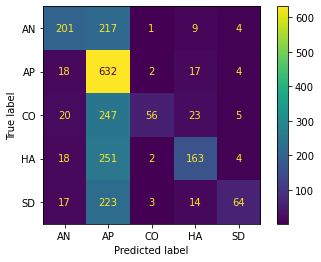

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=text_clf.classes_)
disp.plot()

plt.show()

## Classification report

In [24]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

          AN       0.73      0.47      0.57       432
          AP       0.40      0.94      0.56       673
          CO       0.88      0.16      0.27       351
          HA       0.72      0.37      0.49       438
          SD       0.79      0.20      0.32       321

    accuracy                           0.50      2215
   macro avg       0.70      0.43      0.44      2215
weighted avg       0.66      0.50      0.47      2215



## Parameter tuning with GridSearch CV

In [25]:
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_features': [2, 4, 6, 8],
}

In [27]:
gs_clf = GridSearchCV(text_clf, param_grid, cv=5, n_jobs=-1)

In [29]:
gs_clf = gs_clf.fit(X_train[:500], y_train[:500])

## Now that the classifier is trained, use it to predict the emotion code on a new dream account.

In [41]:
gs_clf.predict(['i saw a snake in the house'])

array(['AP'], dtype='<U2')

## Determine which are the best parameters,

In [32]:
print("Best parameter (CV score=%0.3f):" % gs_clf.best_score_)
print(gs_clf.best_params_)

Best parameter (CV score=0.362):
{'clf__max_features': 2, 'clf__n_estimators': 200}
